# Canny边缘检测算法

Canny边缘检测步骤

1. Gaussian filter
2. Gradient Intensity
3. Non-maximum suppression
4. Double threshold
5. Edge tracking

In [5]:
#coding:utf-8
import numpy as np
%matplotlib  inline
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame

In [6]:
src = cv2.cvtColor(cv2.imread('../datas/f2.jpg'),cv2.COLOR_BGR2RGB)

In [7]:
# 灰度化图片
def rgb2gray(rgb):
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.114]).astype(np.uint8)

In [11]:
# 高斯滤波
def gaussian(im):
    b = np.array([[2, 4,  5,  2,  2],
               [4, 9,  12, 9,  4],
               [5, 12, 15, 12, 5],
               [4, 9,  12, 9,  4],
               [2, 4,  5,  4,  2]]) / 156;
    kernel = np.zeros(im.shape)
    kernel[:b.shape[0], :b.shape[1]] = b

    fim = np.fft.fft2(im)
    fkernel = np.fft.fft2(kernel)
    fil_im = np.fft.ifft2(fim * fkernel)

    return abs(fil_im).astype(int)

Text(0.5,1,'Gaussian')

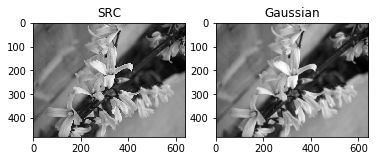

In [13]:
gray = rgb2gray(src)
gaussian_img = gaussian(gray)
plt.subplot(121)
plt.imshow(gray,'gray')
plt.title('SRC')
plt.subplot(122)
plt.imshow(gaussian_img,'gray')
plt.title('Gaussian')

In [18]:
# 图像梯度求解
def gradient(im):
    # Sobel operator
    op1 = np.array([[-1, 0, 1],
                 [-2, 0, 2],
                 [-1, 0, 1]])
    op2 = np.array([[-1, -2, -1],
                 [ 0,  0,  0],
                 [ 1,  2,  1]])
    kernel1 = np.zeros(im.shape)
    kernel1[:op1.shape[0], :op1.shape[1]] = op1
    kernel1 = np.fft.fft2(kernel1)

    kernel2 = np.zeros(im.shape)
    kernel2[:op2.shape[0], :op2.shape[1]] = op2
    kernel2 = np.fft.fft2(kernel2)

    fim = np.fft.fft2(im)
    Gx = np.real(np.fft.ifft2(kernel1 * fim)).astype(float)
    Gy = np.real(np.fft.ifft2(kernel2 * fim)).astype(float)

    G = np.sqrt(Gx**2 + Gy**2)
    Theta = np.arctan(Gy, Gx) * 180 / np.pi
    return G, Theta

float64


Text(0.5,1,'Gradient')

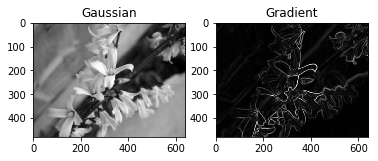

In [65]:
grim,gphase = gradient(gaussian_img)
plt.subplot(121)
plt.title('Gaussian')
plt.imshow(gaussian_img,'gray')
plt.subplot(122)
plt.imshow(grim,'gray')
plt.title('Gradient')

In [31]:
def maximum(det, phase):
    gmax = np.zeros(det.shape)
    for i in range(gmax.shape[0]):
        for j in range(gmax.shape[1]):
            if phase[i][j] < 0:
                phase[i][j] += 360

            if ((j+1) < gmax.shape[1]) and ((j-1) >= 0) and ((i+1) < gmax.shape[0]) and ((i-1) >= 0):
                # 0 degrees
                if (phase[i][j] >= 337.5 or phase[i][j] < 22.5) or (phase[i][j] >= 157.5 and phase[i][j] < 202.5):
                      if det[i][j] >= det[i][j + 1] and det[i][j] >= det[i][j - 1]:
                        gmax[i][j] = det[i][j]
        # 45 degrees
                if (phase[i][j] >= 22.5 and phase[i][j] < 67.5) or (phase[i][j] >= 202.5 and phase[i][j] < 247.5):
                      if det[i][j] >= det[i - 1][j + 1] and det[i][j] >= det[i + 1][j - 1]:
                        gmax[i][j] = det[i][j]
                # 90 degrees
                if (phase[i][j] >= 67.5 and phase[i][j] < 112.5) or (phase[i][j] >= 247.5 and phase[i][j] < 292.5):
                      if det[i][j] >= det[i - 1][j] and det[i][j] >= det[i + 1][j]:
                        gmax[i][j] = det[i][j]
        # 135 degrees
                if (phase[i][j] >= 112.5 and phase[i][j] < 157.5) or (phase[i][j] >= 292.5 and phase[i][j] < 337.5):
                      if det[i][j] >= det[i - 1][j - 1] and det[i][j] >= det[i + 1][j + 1]:
                        gmax[i][j] = det[i][j]
    return gmax

In [91]:
# 双边Threshold
def thresholding(im,low,hi):
    thres  = np.zeros(im.shape)
    strong = 1.0
    weak   = 0.1
    mmax = np.max(im)
    lo, hi = low / 255.0 * mmax, hi / 255.0 * mmax
    strongs = []
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            px = im[i][j]
            if px >= hi:
                thres[i][j] = strong
                strongs.append((i, j))
            elif px >= lo:
                thres[i][j] = weak
    return thres, strongs

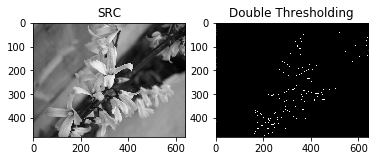

In [92]:
gmax = maximum(grim,gphase)
thres,strongs = thresholding(gmax,40,80)
plt.subplot(121)
plt.imshow(gray,'gray')
plt.title('SRC')
plt.subplot(122)
plt.title('Double Thresholding')
plt.imshow(cv2.convertScaleAbs(thres),'gray')

In [93]:
def tracking(img,weak=0.5,strong=255):
    M, N = img.shape
    for i in range(M):
        for j in range(N):
            if img[i, j] == weak:
                # check if one of the neighbours is strong (=255 by default)
                try:
                    if ((img[i + 1, j] == strong) or (img[i - 1, j] == strong)
                         or (img[i, j + 1] == strong) or (img[i, j - 1] == strong)
                         or (img[i+1, j + 1] == strong) or (img[i-1, j - 1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img

In [94]:
edge = tracking(thres * 255,weak=0.5)


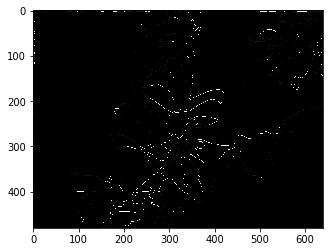

In [95]:
plt.imshow(edge,'gray')

参考：

[1]. https://www.cnblogs.com/mightycode/p/6394810.html
    
[2]. https://blog.csdn.net/trent1985/article/details/45095931

[3]. https://github.com/sebasvega95/Canny-edge-detector